In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output
from jupyterplot import ProgressPlot

from time import time
from collections import defaultdict

import torch
from torch import nn, optim
import torch.nn.functional as F
import math
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output

from math import isqrt

/home/volta/Documents/ucph/scientific_programming/3_assignment/acai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.247, 0.243, 0.261])
transform=torchvision.transforms.Compose([
             torchvision.transforms.ToTensor(),
             torchvision.transforms.Normalize(mean,std) 
         ])

inv_normalize = torchvision.transforms.Normalize(-mean/std,1/std)

dataset = torchvision.datasets.CIFAR10(root='/home/volta/Projects/Bakalarka/data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [3]:
LR = 0.0001
COLORS = 3
activation = nn.LeakyReLU
EPOCHS = 100
BATCH_SIZE = 64
LEAKY_RELU_SLOPE = 0.2
INPUT_SIZE = 32

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        layers = []
        layers.append(nn.Conv2d(in_channels=COLORS, out_channels = 16, kernel_size=1, padding=1))
        layers += [nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers += [nn.Conv2d(16, 16, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers.append(nn.AvgPool2d(2))
        
        layers += [nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers += [nn.Conv2d(8, 8, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers.append(nn.AvgPool2d(2))
        
        #layers += [nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, padding=1), activation(LEAKY_RELU_SLOPE)]
        #layers += [nn.Conv2d(4, 4, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        #layers.append(nn.AvgPool2d(2))
        #
        #layers += [nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1), activation(LEAKY_RELU_SLOPE)]
        #layers += [nn.Conv2d(4, 2, 3, padding=1)]
        
        layers += [nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers += [nn.Conv2d(8, 4, 3, padding=1)]
        
        self.layer = nn.Sequential(*layers)
        
    def forward (self,x):
        return self.layer(x)
    
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        layers = []
        
        #layers += [nn.Conv2d(2, 4, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        #layers += [nn.Conv2d(4, 4, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        #layers.append(nn.Upsample(scale_factor=2))
        
        layers += [nn.Conv2d(4, 8, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers += [nn.Conv2d(8, 8, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers.append(nn.Upsample(scale_factor=2))
        
        layers += [nn.Conv2d(8, 16, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers += [nn.Conv2d(16, 16, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers.append(nn.Upsample(scale_factor=2))
        
        layers += [nn.Conv2d(16, 16, 3, padding=1), activation(LEAKY_RELU_SLOPE)]
        layers.append(nn.Conv2d(16, COLORS, 3, padding=1))
        
        self.layer = nn.Sequential(*layers)
        
    def forward (self,x):
        return self.layer(x)
    
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.encoder = Encoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = torch.mean(x, -1)
        return x

In [5]:
def squared_l2(x):
    return torch.norm(x)**2

In [6]:
def swap(x):
    a, b = x.split(math.ceil(x.shape[0]/2))
    return torch.cat([b, a])

In [7]:
def mean_of_squares ( x ):
    return torch.mean(x**2)

In [8]:
encoder = Encoder().cuda() 
decoder = Decoder().cuda()
critic = Critic().cuda()

ae_optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=LR)
critic_optim = torch.optim.Adam(critic.parameters())

In [9]:
def create_mosaic(torch_array):
    array = inv_normalize(torch_array)
    grid = torchvision.utils.make_grid(array)
    return torchvision.transforms.ToPILImage()(grid)
    
def reconstruct(x):
    return decoder(encoder(x))

In [10]:
def interpolate_2(x):
    n_imgs = x.shape[0] 
    split = n_imgs // 2 
    if n_imgs % 2 != 0:
        raise ValuError('The number of images has to be divisible by 2')
    
    z = encoder(x)
    
    alpha = torch.linspace(0,1,split).reshape(-1,1,1,1).to('cuda')
    
    a = z[split:]
    b = z[:split]
    
    interpolations = [ a * (1 - al ) + b * al for al in alpha ]
    
    res = [decoder(z) for z in interpolations]
    
    return torch.cat(res)
    

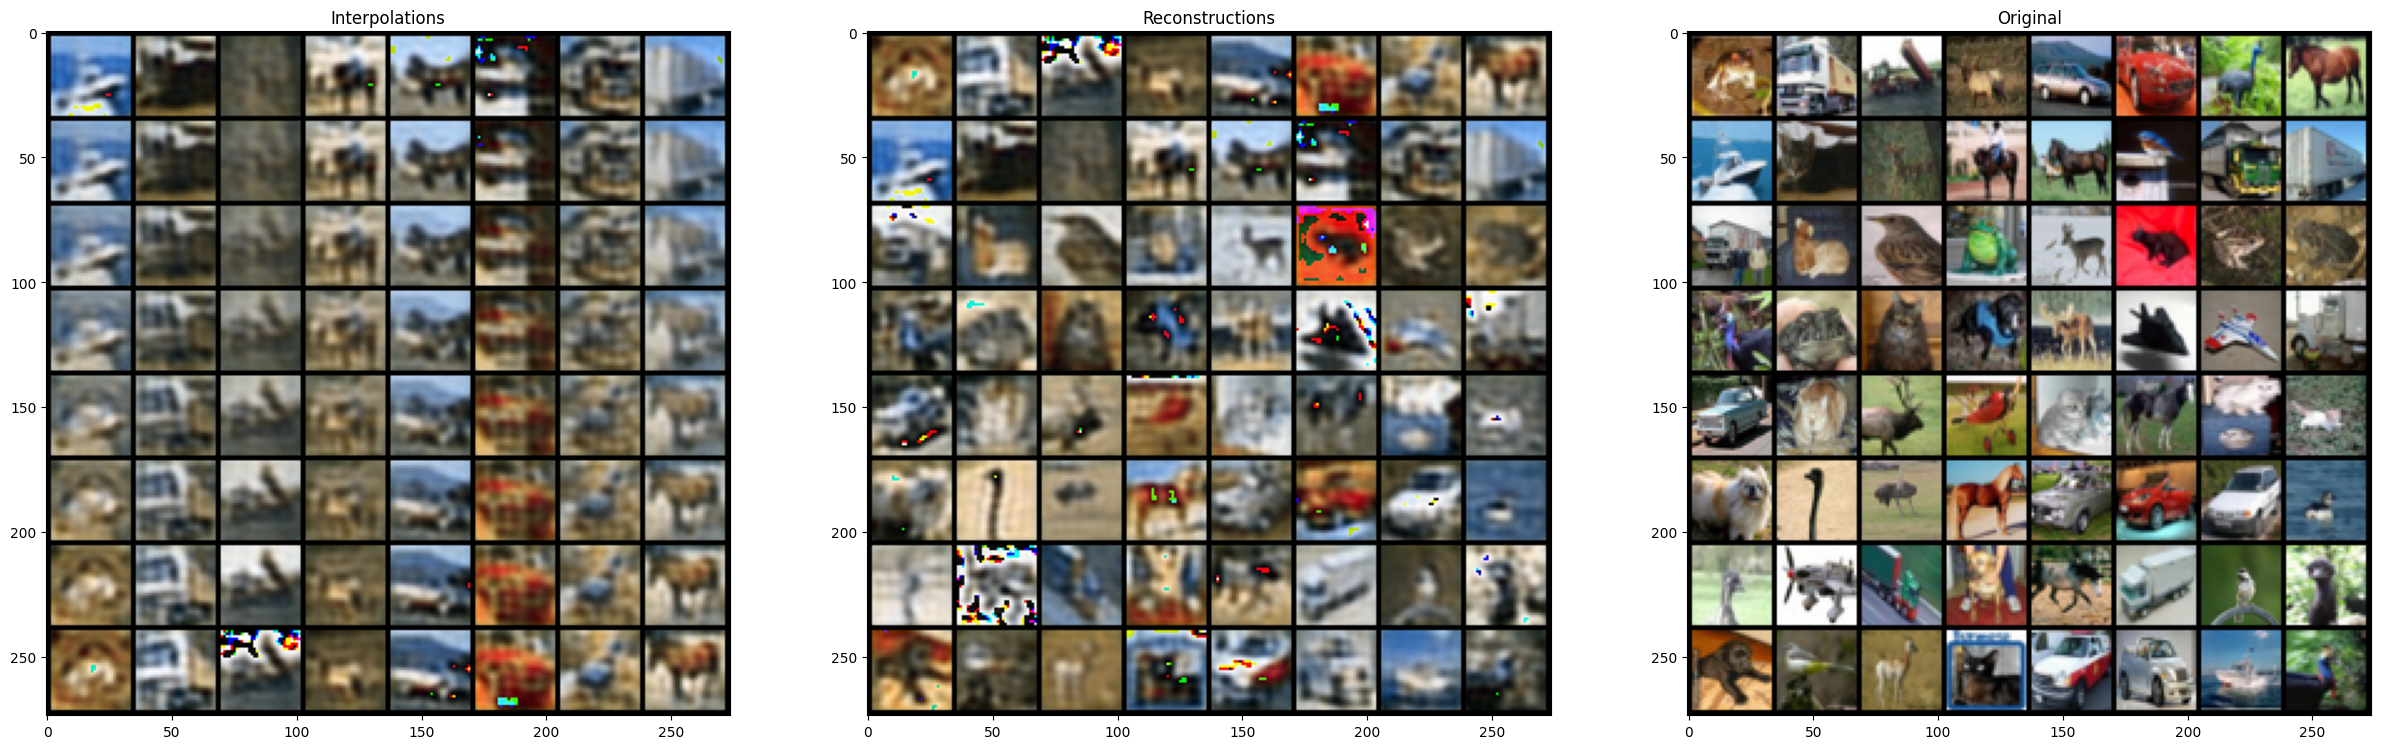

1601.2999606132507


In [11]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=12)

reconstruction_sample = next(iter(dataloader))[0][:8**2].to('cuda')
interpolation_sample = next(iter(dataloader))[0][:16].to('cuda')
original_sample = next(iter(dataloader))[0][:8**2]

start = time()

l_param = 0.5
g_param = 0.2

#pp = ProgressPlot(line_names=[ "std of criti", "critic_loss", "ae_loss"])

for epoch in range(EPOCHS):
    
    for batch in dataloader:
        
        ae_optim.zero_grad()
        critic_optim.zero_grad()
        
        batch = batch[0].to('cuda')
        
        z1 = encoder(batch)
        ae_out = decoder(z1)
        
        alpha = torch.FloatTensor(batch.shape[0],1,1,1).uniform_(0,0.5).to('cuda')
        
        x_alpha = decoder(torch.lerp(swap(z1),z1,alpha))
        
        cr_x_alpha = critic(x_alpha)
        
        ae_loss = F.mse_loss(ae_out, batch) + l_param * mean_of_squares(cr_x_alpha)
        
        critic_loss = F.mse_loss(cr_x_alpha, alpha.reshape(-1)) + mean_of_squares(critic(torch.lerp(ae_out,batch, g_param)))
        
        #pp.update([[torch.std(cr_x_alpha).item(),critic_loss,ae_loss]])
                                                                       
        ae_loss.backward(retain_graph=True)
        critic_loss.backward()
        
        ae_optim.step()
        critic_optim.step()        
        
    interp_mosaic = create_mosaic(interpolate_2(interpolation_sample))
    reconstruct_mosaic = create_mosaic(reconstruct(reconstruction_sample))
    original = create_mosaic(original_sample)
    
    clear_output(wait=True)
    
    fig,ax = plt.subplots(1,3,figsize=(30,10))
    ax[0].imshow(interp_mosaic)
    ax[0].set_title('Interpolations')
    ax[1].imshow(reconstruct_mosaic)
    ax[1].set_title('Reconstructions')
    ax[2].imshow(original)
    ax[2].set_title('Original')
    
    plt.show()
        
        
end = time()
print(end-start)

In [12]:
torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(), 'decoder.pt')
torch.save(critic.state_dict(), 'critic.pt')

In [26]:
encoder.eval()
decoder.eval()
critic.eval()

Critic(
  (encoder): Encoder(
    (layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2)
      (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.2)
      (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): LeakyReLU(negative_slope=0.2)
      (13): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [23]:
model = Encoder().cpu()
model.load_state_dict(torch.load('encoder.pt'))

<All keys matched successfully>

In [28]:
inference = DataLoader(dataset, batch_size=256, num_workers=12)

In [32]:
latent_space = []
with torch.no_grad():
    for i,j in inference:
        latent_space.append(encoder(i.to('cuda')).cpu().numpy())

In [36]:
np.concatenate(latent_space).reshape(-1,4*8*8)

(50000, 256)